<a href="https://colab.research.google.com/github/phytometrics/plant_phenotyping_python/blob/main/notebooks/sai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAI:シロイヌナズナ表皮画像気孔開度定量
![stomata analysis result](https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/sai.png?raw=true)

気孔開度自動定量プログラム(StomaAI, SAI)を用いてシロイヌナズナ表皮から気孔開口領域の検出結果

## ライセンス
- Sai et al., New Phytol., 2023 (https://nph.onlinelibrary.wiley.com/doi/10.1111/nph.18765)
    - CC-BY-NC
- SAIレポジトリ
    - https://github.com/XDynames/SAI-app
    - GPLv3
- Detectron2
    - https://github.com/facebookresearch/detectron2
    - Apache 2.0
- 本稿ノートブック
    - GPLv3

## 解説
筆者ら（開発者ら）は、顕微鏡画像から植物の気孔開度を測るために、次の情報を画像から抽出する深層学習ネットワークを訓練しました。
1. 気孔のbounding box coordinate
2. 気孔開口領域のpolygon coordinate
3. 長軸方向における孔辺細胞の両端（開口した際の縁）と中心のkeypoint coordinate

1と２のステップから気孔の状態（開口か閉鎖か）、さらには3によって孔辺細胞の長軸方向が定まります。
本アルゴリズムでは、Detectron2ライブラリを活用しています。「カリフラワーインスタンスセグメンテーションモデルの作成」ではDetecron2を使い、インスタンスセグメンテーションモデルを作成しましたが、本ライブラリは他にも、物体検出、キーポイント検出、マスクセグメンテーションなどの多様なタスクにも使えます。ここでは、気孔開度検出のためにマルチタスクに対応したモデルを訓練し、使用しています。

## 環境構築・データ準備

In [1]:
# FIGSHARE_ROOT = "https://adelaide.figshare.com/ndownloader/files/"
# FIGSHARE_ID = ["44323415", "44323421","44323424", "44323427"]
# image_urls = [FIGSHARE_ROOT + x for x in FIGSHARE_ID]
# import os
# !mkdir images
# for i, url in enumerate(image_urls):
#     !wget -q -O {"images/"+str(i).zfill(3)+".jpg"} {url}
# !wget -q -O arabidipsis_weights.pth {FIGSHARE_ROOT + "44321711"}
# !wget -q -O arabidosis_config.yaml {FIGSHARE_ROOT + "44321570"}
# !wget -q -O Base-RCNN-FPN.yaml {FIGSHARE_ROOT + "44321576"}

!wget -O data.zip https://www.dropbox.com/scl/fo/smpth5l0oh2d0gwp9aqc3/AMGiD7v_gE5Oyuy_Wp0P0tI?rlkey=lpk0eopjzi5q3n8imldju56gv&st=cxxeta2f&dl=1
!unzip -d images data.zip
!mv images/arabidopsis_config.yaml ./
!mv images/arabidopsis_weights.pth ./
!mv images/Base-RCNN-FPN.yaml ./
!rm data.zip

In [3]:
!git clone https://github.com/XDynames/SAI-app.git

Cloning into 'SAI-app'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 203 (delta 60), reused 49 (delta 41), pack-reused 111
Receiving objects: 100% (203/203), 965.44 KiB | 31.14 MiB/s, done.
Resolving deltas: 100% (106/106), done.


In [4]:
!pip3 install git+https://github.com/facebookresearch/detectron2.git

  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=6120379 sha256=4aa5332fc07de86d2e453b7cd2b0f9ab51bd94d4d3377ce707ed7934c36dfd18
  Stored in directory: /tmp/pip-ephem-wheel-cache-h324msqa/wheels/47/e5/15/94c80df2ba85500c5d76599cc307c0a7079d0e221bb6fc4375
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=6689e140a85a9f2069e28cceb4d0ec790825f7febd32726a6889b61079c085c7
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=7be2f38a22baecd05fd54312477fce79aee7cdd18a4d0cd136f3411d0a49e407
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built detectron2 fvcore antlr4-python3-runtime


In [5]:
!pip install streamlit  # 使わないものの、import error対策としてインストールする
!pip install shapely
!pip install mask_to_polygons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of mask-to-polygons to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 62.8 MB/s eta 0:00:00
  Created wheel for Shapely: filename=Shapely-1.6.4.post2-py2.py3-none-any.whl size=157354 sha256=e879621c8c857446aefacb53e67a7809f2ebf204459d9bd1ec865d15c7bda508

## 推論

In [6]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import pandas as pd

import detectron2
from detectron2.data import MetadataCatalog
from detectron2.engine.defaults import DefaultPredictor
from detectron2.utils.visualizer import ColorMode, Visualizer

SAIライブラリを読み込みます。本ライブラリはstreamlitと呼ばれるブラウザを通じてアプリケーションを実行するためのフレームワークで動作することを前提としています（後述）。state.py内に記述されているcamera_calibrationパラメーターはブラウザからのみ変更可能であり、コマンドラインから入力できません。したがって、sedコマンドを使用してcamera_calibrationパラメーターを強制的に書き込みます。

In [7]:
%cd SAI-app
!sed -i '18s/.*/"camera_calibration": 10.25131,/' /content/SAI-app/tools/state.py
from app import utils
from app.inference import predictions_to_list_of_dictionaries
from app.example_images import draw_bounding_boxes, draw_measurements

from inference.modeling.stoma_head import KRCNNConvHead, KPROIHeads
from inference.post_processing import get_indices_of_valid_predictions

/content/SAI-app


2024-02-03 06:59:14.496 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2024-02-03 06:59:14.499 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [8]:
def get_config():
    cfg = detectron2.config.get_cfg()
    cfg.MODEL.ROI_KEYPOINT_HEAD.POOLER_RESOLUTION = (14, 14)
    cfg.merge_from_file("/content/arabidosis_config.yaml")
    cfg.MODEL.WEIGHTS = "/content/arabidipsis_weights.pth"
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.6
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = (0.6)
    if torch.cuda.is_available():
        cfg.MODEL.DEVICE = "cuda"
    cfg.freeze()
    return cfg

config = get_config()

In [32]:
predictor = DefaultPredictor(config)

  pixel_mean
  pixel_std


In [33]:
path = "/content/images/000.jpg"
image = cv2.imread(path)

In [34]:
## demo.run_on_image
with torch.no_grad():
    predictions = predictor(image)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


出力された変数の中身を確認してみましょう。

In [58]:
print(type(predictions))
print(predictions.keys())
print(len(predictions["instances"]))
print(type(predictions["instances"]))

<class 'dict'>
dict_keys(['instances'])
<class 'detectron2.structures.instances.Instances'>
4


推論結果は辞書型であり、instancesキーの中にdetectron2のInstancesクラスとして結果が格納されています。４気孔分検出されたことを意味しています。
タスクによって格納されている結果は異なります。今回は気孔検出座標のpred_boxes、検出確度のscores、推論ラベル（開閉）のpred_classes、気孔開口領域マスクのpred_masks、気孔開口領域の両端と中心座標（pred_keypoijnts）が含まれています。

詳細は https://detectron2.readthedocs.io/en/latest/tutorials/models.html#model-input-format


In [79]:
print(predictions["instances"].pred_boxes)
print(predictions["instances"].scores)
print(predictions["instances"].pred_classes)
print(predictions["instances"].pred_masks)
print(predictions["instances"].pred_keypoints)

Boxes(tensor([[1136.8234, 1338.6442, 1342.4559, 1575.1012],
        [ 326.4964, 1084.6667,  522.4889, 1294.5828],
        [1910.3730,  407.0862, 2150.8108,  646.3732],
        [1058.8499,  876.1246, 1243.2207, 1133.7671]], device='cuda:0'))
tensor([0.9998, 0.9997, 0.9982, 0.9903], device='cuda:0')
tensor([1, 1, 1, 1], device='cuda:0')
tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False,

推論結果を後処理します。ここではsaiの関数をそのまま利用します。重複する場所に検出された気孔や、画面端の気孔を取り除き、計測に有効な推論結果（valid predictions）のみ残すことを行っています。フィルタリングされた結果から、select_predictionsを用いて気孔開度を算出しています。

In [ ]:
## _post_process_predictions
instances = predictions["instances"].to(torch.device("cpu"))
valid_indices = get_indices_of_valid_predictions(instances)
predictions["instances"] = instances
## return predictions, valid_indices

## run_on_image
valid_indices = get_indices_of_valid_predictions(instances)
# return  predictions["instances"], time_elapsed, valid_indices
predictions, valid_indices = predictions_to_list_of_dictionaries(
    predictions["instances"], valid_indices
)
valid_predictions = utils.select_predictions(predictions, valid_indices)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


結果を見てみましょう。今回の画像では、結果的に除去された推論結果はありませんでしたので検出結果は４つとかわりありません。

In [ ]:
[{"stoma_id": d["stoma_id"], "length": d["length"], "width": d["width"]} for d in valid_predictions]

[{'stoma_id': 0, 'length': 71.00892970446178, 'width': 23.026221431244245},
 {'stoma_id': 1, 'length': 69.61520062581617, 'width': 20.77074644826692},
 {'stoma_id': 2, 'length': 107.2053577518041, 'width': 15.350873966697863},
 {'stoma_id': 3, 'length': 87.53600243639858, 'width': 18.346918919175476}]

描画します

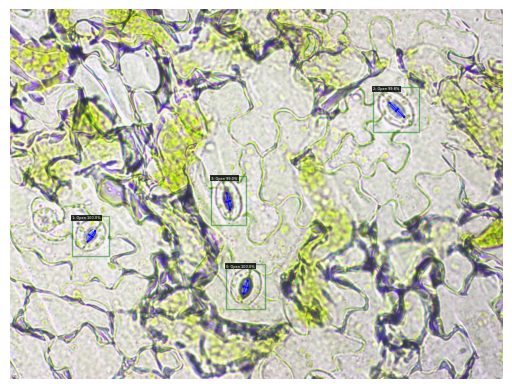

In [ ]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(image)
。
draw_measurements(ax, valid_predictions)
draw_bounding_boxes(ax, predictions)


## おまけ
SAIのレポジトリはブラウザで解析を可能とするstreamlitを活用しています。

レポジトリに従って環境構築すれば自身のPCでGUIベースのプログラムを走らせることが可能です。

また、筆者らによるオンラインサービス（https://sai.aiml.team/）　も提供されているので興味のある方は確認してみてください。

<img width=50% src="https://github.com/phytometrics/plant_phenotyping_python/blob/main/notebooks/imgs/sai_streamlit.png?raw=true">

https://sai.aiml.team/ のスクリーンショット。Arabidopsisの他に、barleyのモデルも提供されています。


本稿のコードはレポジトリから解析部分のみを抜粋し、Colaboratoryで動作するようにカスタマイズしたものです。